In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
# from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [2]:
from sklearn.feature_selection import mutual_info_regression

## checagem de mutual information para todos os datasets juntos

In [ ]:
mutual_list = []
for j in ['001','002','003','004']:
    files = sorted([i for i in os.listdir() if i.find(j)!=-1])
    files
    # CRIAÇÃO DOS NOMES DAS COLUNAS
    columns = ['engine','cicle']+[f'setting_{i+1}' for i in range(3)]+[f'sensor_{i+1}' for i in range(21)]
    # IMPORTAÇÃO DO DATA FRAME
    df_train = pd.read_csv(files[2],header=None,sep=' ')
    # EXCLUI COLUNAS VAZIAS
    df_train.drop(columns=[26,27],inplace=True)
    # RENOMEIA AS COLUNAS
    df_train.columns = columns
    # CRIA UMA COLUNA DE CICLO MAXIMO PARA CADA MOTOR
    df_train = df_train.merge(df_train.groupby('engine').max()['cicle'].reset_index().rename(columns = {'cicle':'max_cicle'}),on='engine',how='left')
    # CRIA UMA COLUNA DE ROC PARA CADA LINHA
    df_train['ROC'] = df_train['max_cicle'] - df_train['cicle']
    # COLUNAS COM BAIXA CORRELAÇÃO COM ROC
    df_train.drop(columns=['engine','cicle','max_cicle'],inplace=True)
    # SEPARA O DATAFRAME EM X E Y
    train_X = df_train.drop(columns='ROC')
    train_Y = df_train['ROC']
    # APLICA A REGRESSÃO DE INFORMAÇÃO MUTUA PARA DESCOBRIR AS COLUNAS RELEVANTES PARA O MODELO
    res = mutual_info_regression(train_X,train_Y)
    mutual_info = pd.Series(dict(zip(train_X.columns.tolist(),res))).sort_values(ascending=False)
    mutual_list.append(mutual_info)

mutual_list = pd.concat(mutual_list,axis=1)

mutual_list['mean'] = mutual_list.mean(axis=1)

mutual_list = mutual_list.sort_values('mean',ascending=False)

<AxesSubplot:>

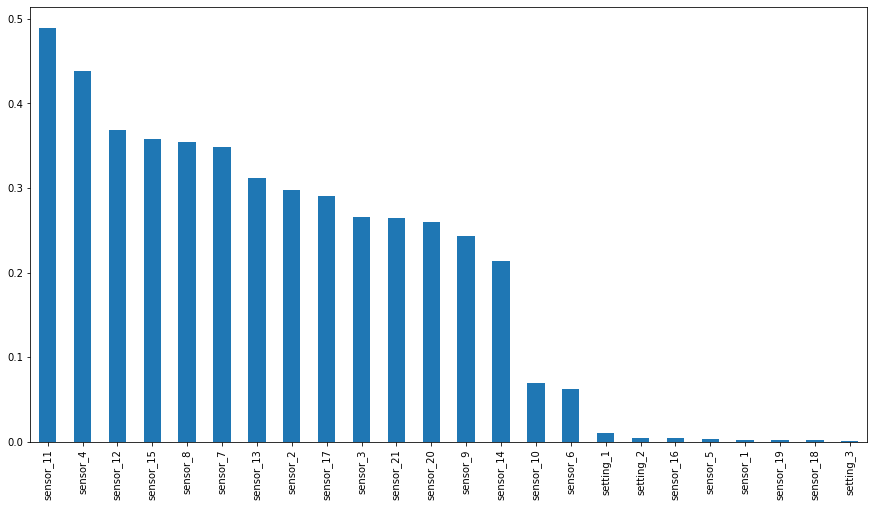

In [278]:
mutual_list['mean'].plot.bar(figsize=(15,8))

In [251]:
files = sorted([i for i in os.listdir() if i.find('003')!=-1])
files

['RUL_FD003.txt', 'test_FD003.txt', 'train_FD003.txt']

### Importação do treino

In [252]:
# CRIAÇÃO DOS NOMES DAS COLUNAS
columns = ['engine','cicle']+[f'setting_{i+1}' for i in range(3)]+[f'sensor_{i+1}' for i in range(21)]
# IMPORTAÇÃO DO DATA FRAME
df_train = pd.read_csv(files[2],header=None,sep=' ')
# EXCLUI COLUNAS VAZIAS
df_train.drop(columns=[26,27],inplace=True)
# RENOMEIA AS COLUNAS
df_train.columns = columns
# CRIA UMA COLUNA DE CICLO MAXIMO PARA CADA MOTOR
df_train = df_train.merge(df_train.groupby('engine').max()['cicle'].reset_index().rename(columns = {'cicle':'max_cicle'}),on='engine',how='left')
# CRIA UMA COLUNA DE ROC PARA CADA LINHA
df_train['ROC'] = df_train['max_cicle'] - df_train['cicle']
# COLUNAS COM BAIXA CORRELAÇÃO COM ROC
df_train.drop(columns=['engine','cicle','max_cicle'],inplace=True)
# SEPARA O DATAFRAME EM X E Y
train_X = df_train.drop(columns='ROC')
train_Y = df_train['ROC']

In [253]:
# APLICA A REGRESSÃO DE INFORMAÇÃO MUTUA PARA DESCOBRIR AS COLUNAS RELEVANTES PARA O MODELO
res = mutual_info_regression(train_X,train_Y)
mutual_info = pd.Series(dict(zip(train_X.columns.tolist(),res))).sort_values(ascending=False)

In [250]:
mutual_info[mutual_info>0.08].index.isin(['sensor_11',
                                                                     'sensor_4',
                                                                     'sensor_12',
                                                                     'sensor_7',
                                                                     'sensor_15',
                                                                     'sensor_21',
                                                                     'sensor_20',
                                                                     'sensor_2',
                                                                     'sensor_17',
                                                                     'sensor_3',
                                                                     'sensor_13',
                                                                     'sensor_8',
                                                                     'sensor_14',
                                                                     'sensor_9'])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True])

In [242]:
mutual_info[mutual_info>0.20].index.tolist()

['sensor_11',
 'sensor_4',
 'sensor_12',
 'sensor_7',
 'sensor_15',
 'sensor_21',
 'sensor_20',
 'sensor_2',
 'sensor_17',
 'sensor_3',
 'sensor_13',
 'sensor_8',
 'sensor_14',
 'sensor_9']

In [9]:
train_X = train_X[['sensor_11',
                             'sensor_4',
                             'sensor_12',
                             'sensor_7',
                             'sensor_15',
                             'sensor_21',
                             'sensor_20',
                             'sensor_2',
                             'sensor_17',
                             'sensor_3',
                             'sensor_13',
                             'sensor_8',
                             'sensor_14',
                             'sensor_9']]

### Importação do teste

In [25]:
# IMPORTAÇÃO DO DATA FRAME
test_X = pd.read_csv(files[1],header=None,sep=' ')
# EXCLUI COLUNAS VAZIAS
test_X.drop(columns=[26,27],inplace=True)
# RENOMEIA AS COLUNAS
test_X.columns = columns

test_X = test_X.groupby('engine').last().reset_index()

test_X = test_X[[i for i in df_train.columns if i in test_X.columns]]

test_Y = pd.read_csv(files[0],header=None,sep=' ')[0]

### Dropar colunas com alta e baixa correlação

In [17]:
df_train = pd.concat([train_X,train_Y],axis=1)

<AxesSubplot:>

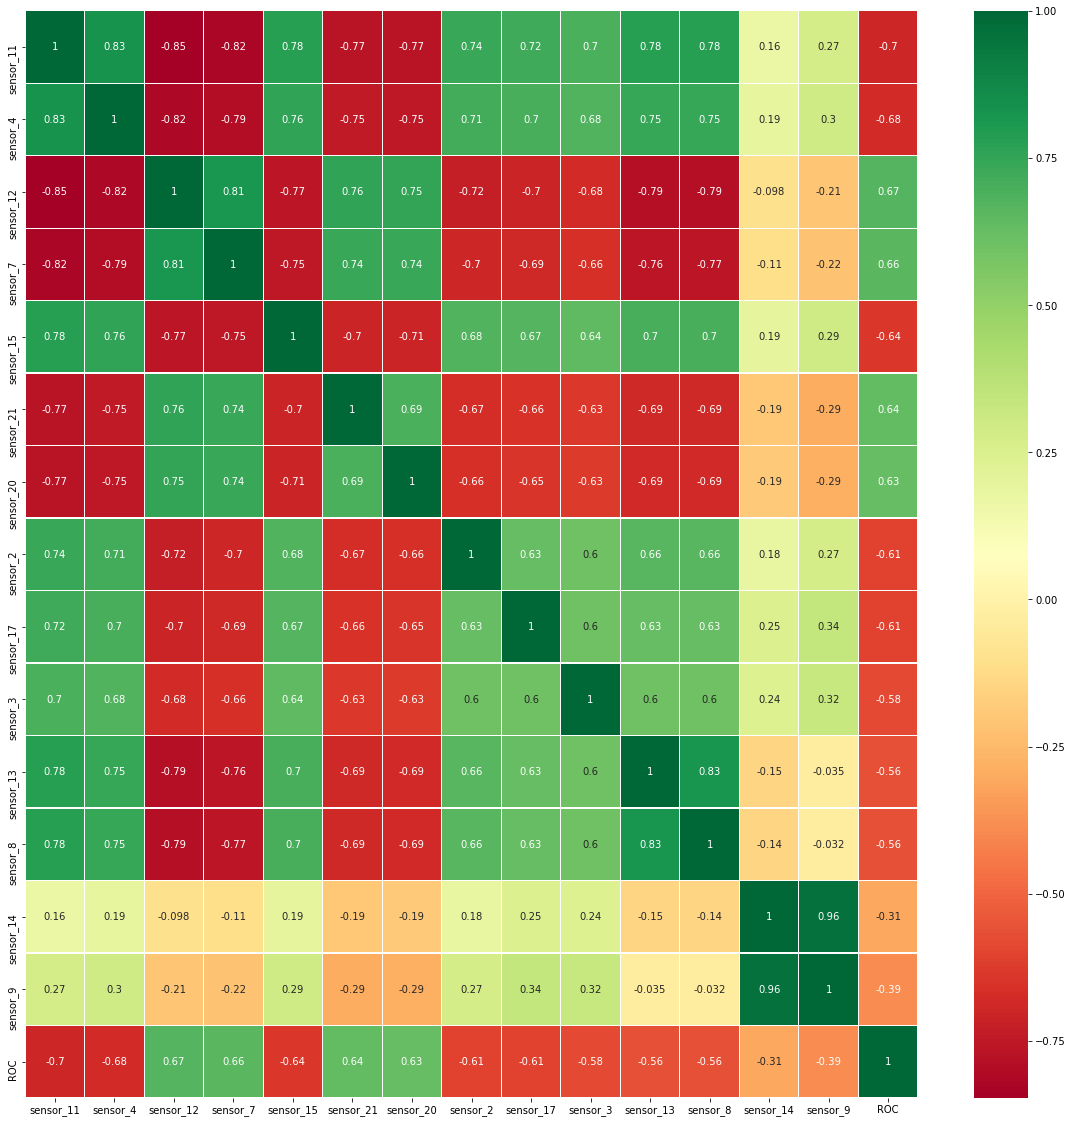

In [18]:
fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)

### Avaliar cada coluna

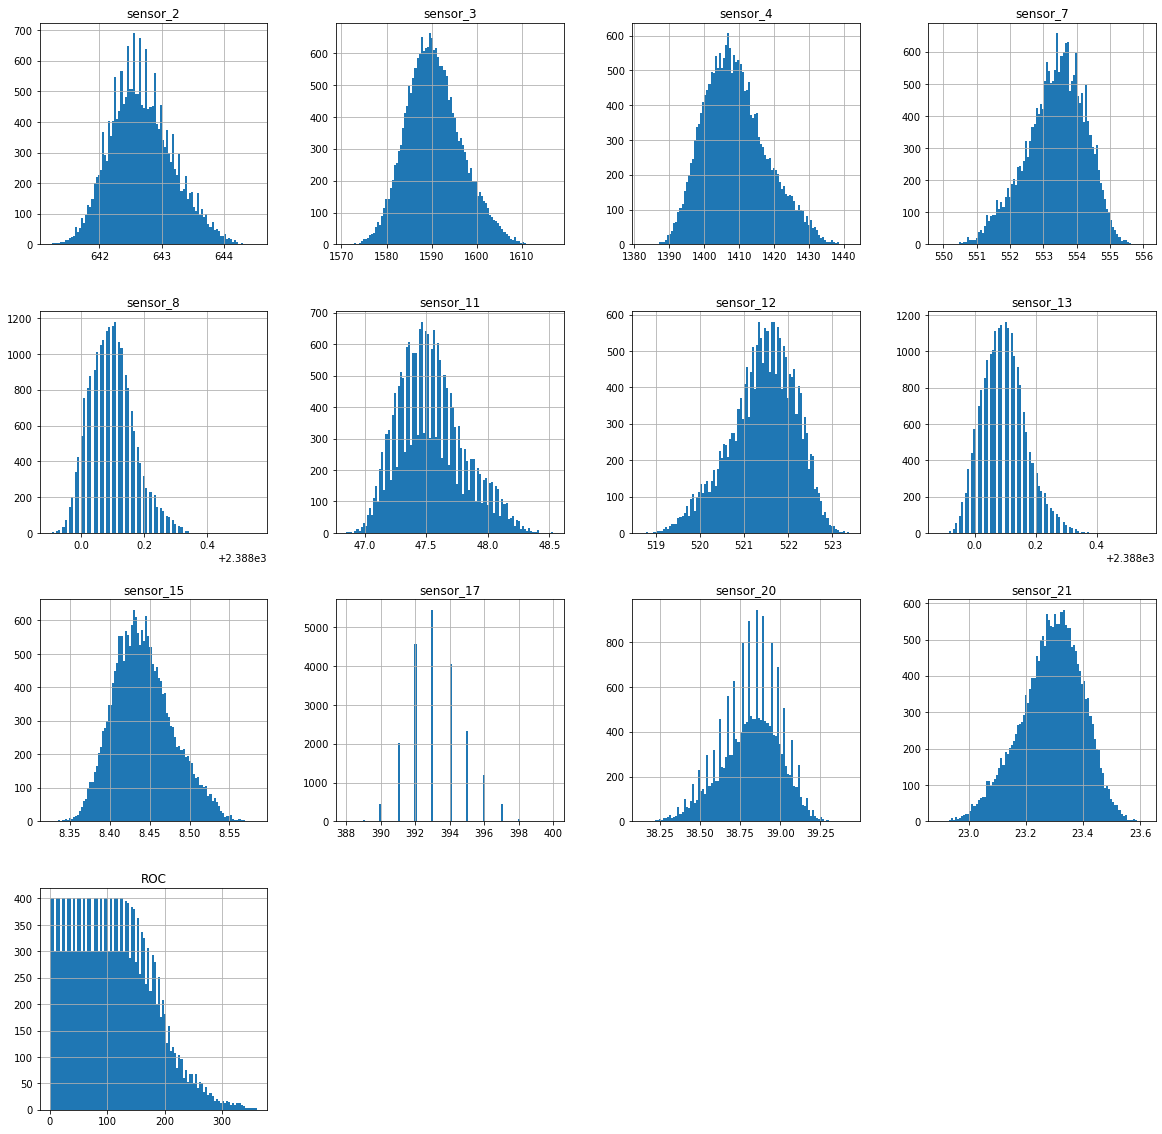

In [40]:
df_train.hist(bins=100,figsize=(20,20));

## PCA

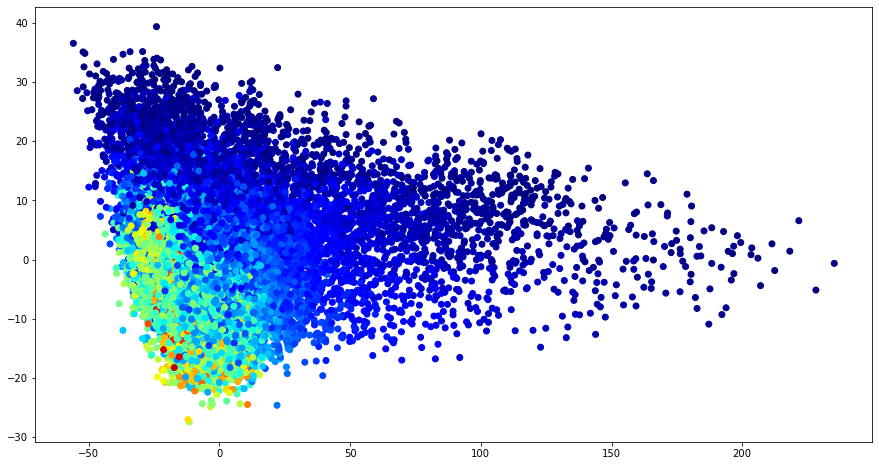

In [19]:
pca = PCA(n_components=2)
pca.fit(np.array(df_train.drop(columns='ROC')))
X = pca.transform(np.array(df_train.drop(columns='ROC')))
norm = plt.Normalize()
colors = plt.cm.jet(norm(df_train['ROC']))
fig,ax = plt.subplots(figsize=(15,8))
ax.scatter(X.T[0],X.T[1],color=colors)

Correlação com o primeiro componente é relativamente alta

In [20]:
pd.concat([pd.DataFrame(X),df_train['ROC']],axis=1).corr()

,0,1,ROC
0,1.000000e+00,1.949558e-14,-0.381517
1,1.949558e-14,1.000000e+00,-0.613988
ROC,-3.815167e-01,-6.139878e-01,1.000000


## Regression

In [21]:
from scipy.optimize import minimize,Bounds

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.svm import SVR,NuSVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import math

In [228]:
 def score_plot(i):
    if i>=0:
        return np.exp(i/10)-1
    else:
        return np.exp(-i/13)-1

In [233]:
def loss_score(y_true,y_pred,a1=10,a2=13):
    d = y_pred - y_true
    low_rul_wheights = 2*np.exp((np.array(y_pred)*-1/2))+1
    scores  = np.array([score_plot(i) for i in d])
    return (scores*low_rul_wheights).sum()

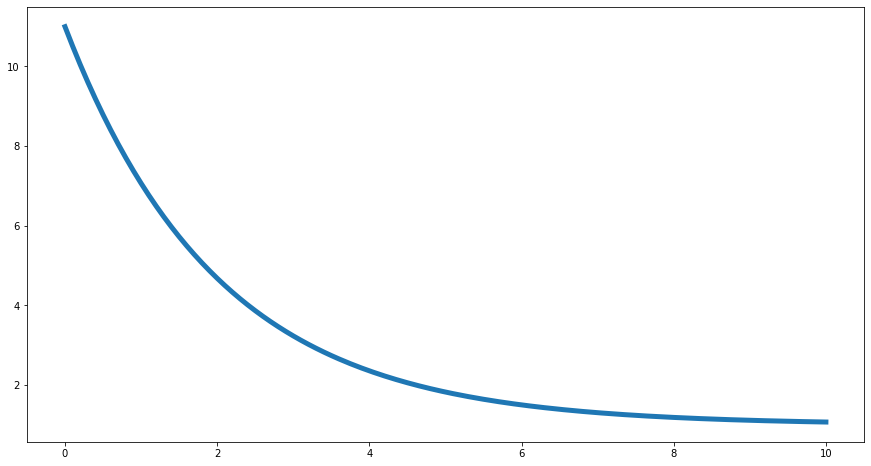

In [207]:
x = np.linspace(0,10,201)
y = np.array([10*math.exp(-i/2)+1 for i in x])

plt.figure(figsize=(15,8))
plt.plot(x,y,lw=5)

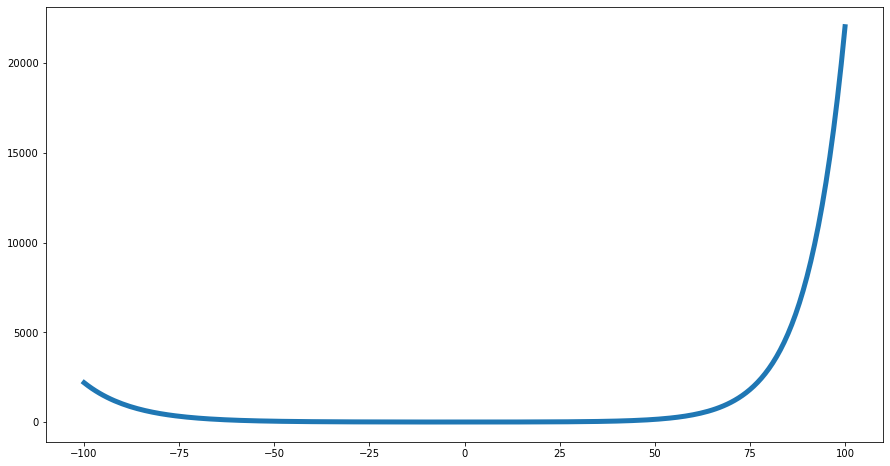

In [206]:
x = np.linspace(-100,100,201)
y = np.array([score_plot(i) for i in np.linspace(-100,100,201)])

plt.figure(figsize=(15,8))
plt.plot(x,y,lw=5)

In [230]:
def get_score(test_Y,prediction):
    print(f'Competition Score: {loss_score(np.array(test_Y), prediction)}')
    print(f'MSE: {mean_squared_error(np.array(test_Y), prediction)}')
    print(f'R2 score: {r2_score(np.array(test_Y), prediction)}')
    print(f'MAE: {mean_absolute_error(np.array(test_Y), prediction)}')
    return [loss_score(np.array(test_Y), prediction),mean_squared_error(np.array(test_Y), prediction),r2_score(np.array(test_Y), prediction),mean_absolute_error(np.array(test_Y), prediction)]

In [26]:
std_scale = StandardScaler().fit(train_X)
train_X_std = std_scale.transform(train_X)
test_X_std  = std_scale.transform(test_X)

In [163]:
minimize(optmize_params,900)['x']

array([900.])

In [27]:
def optmize_params(train_X_std=train_X_std,train_Y=train_Y,test_X_std=test_X_std,test_Y=test_Y):
    regr = regr = MLPRegressor(hidden_layer_sizes=(100,),
                                    activation='relu',
                                    warm_start=True,
                                    verbose=False,
                                    solver='adam',
                                    learning_rate_init=0.001,
                                    max_iter=400).fit(train_X_std, train_Y)
    prediction = regr.predict(test_X_std)
    return mean_squared_error(np.array(test_Y), prediction)

In [76]:
results ={}

Competition Score: 2505.2806868148396
MSE: 452.6400095921417
R2 score: 0.7378840825085219
MAE: 16.43905352009073


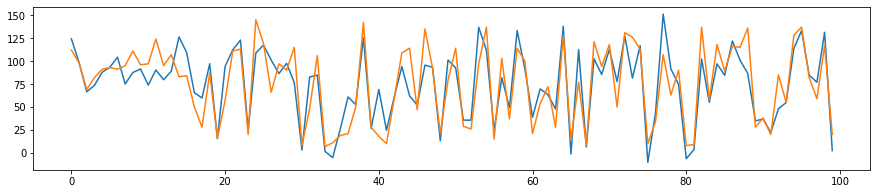

In [234]:
regr = LinearSVR(C=0.0135)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['LinearSVR'] = get_score(test_Y,prediction);

Competition Score: 26463.09841213692
MSE: 899.2393503659448
R2 score: 0.4792662107399742
MAE: 23.775462455693805


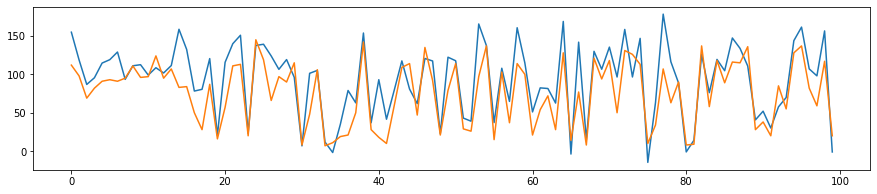

In [235]:
regr = MLPRegressor(hidden_layer_sizes=(100,50,50),
                                    activation='identity',
                                    warm_start=True,
                                    verbose=False,
                                    solver='adam',
                                    learning_rate_init=0.001,
                                    max_iter=200)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['MLPRegressor'] = get_score(test_Y,prediction);

Competition Score: 2497355.292463524
MSE: 2731.8
R2 score: -0.5819376286431821
MAE: 36.52


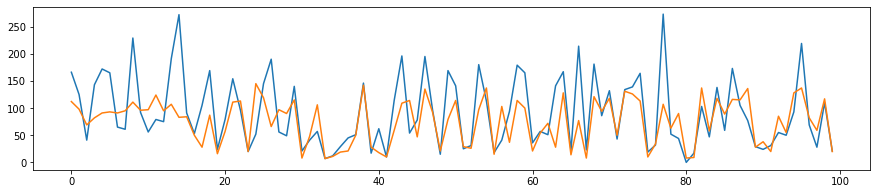

In [103]:
regr = DecisionTreeRegressor()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['DecisionTreeRegressor'] = get_score(test_Y,prediction);

Competition Score: 2858.1220538416815
MSE: 975.8649602285029
R2 score: 0.434893659470001
MAE: 24.463938106798608


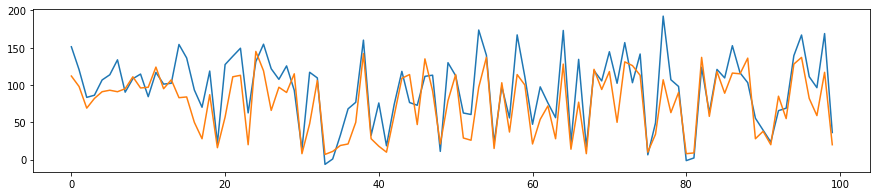

In [114]:
regr = PLSRegression(n_components=1)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction.T[0]))
ax.plot(test_Y)

results['PLSRegression'] = get_score(test_Y,prediction.T[0]);

Competition Score: 2507.412102901502
MSE: 947.5237830249307
R2 score: 0.45130553979007393
MAE: 24.15157894736842


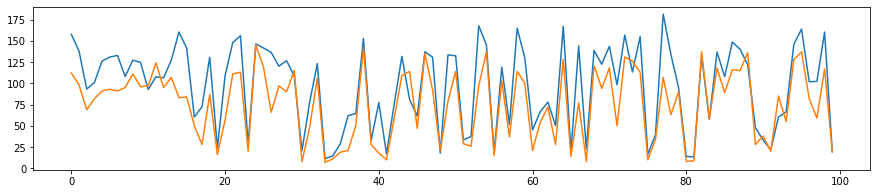

In [118]:
regr = KNeighborsRegressor(n_neighbors=950,leaf_size=30)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['KNeighborsRegressor'] = get_score(test_Y,prediction);

Competition Score: 1913.6880499461197
MSE: 907.3895998665517
R2 score: 0.47454654371902083
MAE: 24.64437330587889


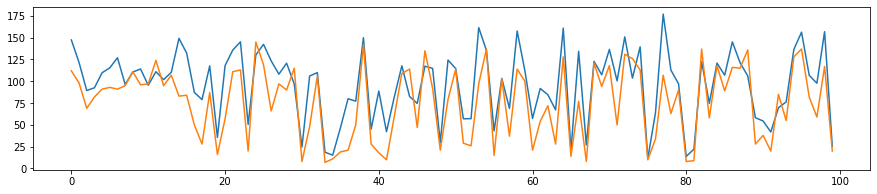

In [119]:
regr = linear_model.SGDRegressor(alpha=1,epsilon=5,verbose=0)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['SGDRegressor'] = get_score(test_Y,prediction);

MSE: 454.89218304502583
R2 score: 0.7365798882295305
MAE: 16.492385359285848


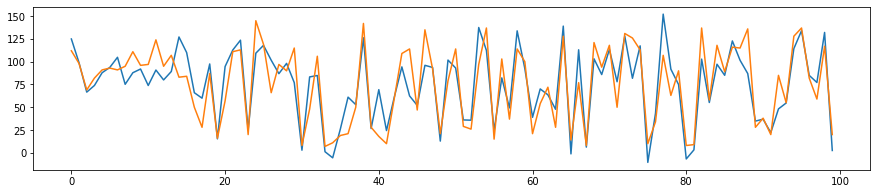

In [35]:
regr = LinearSVR(C=0.014)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['LinearSVR'] =get_score(test_Y,prediction);

MSE: 471.04919784754776
R2 score: 0.7272236433790091
MAE: 16.766714473544333


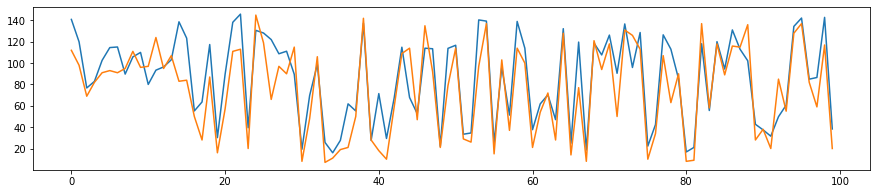

In [36]:
regr = NuSVR(nu=0.95,C=0.06)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['NuSVR'] =get_score(test_Y,prediction);

Competition Score: 790.7796415309753
MSE: 467.57279988916605
R2 score: 0.7292367646699172
MAE: 16.66797737782659


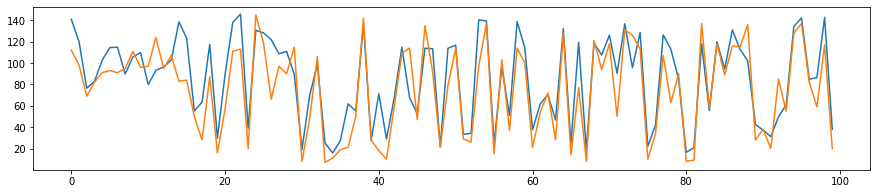

In [120]:
regr = SVR(C=0.06, epsilon=0.1)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['SVR'] =get_score(test_Y,prediction);

Competition Score: 3580.444731629214
MSE: 1039.2600433428556
R2 score: 0.3981826749727624
MAE: 24.030405450216957


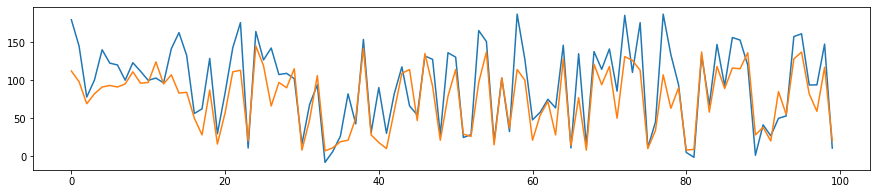

In [121]:
poly = PolynomialFeatures(degree=3)
train = poly.fit_transform(train_X_std)
test = poly.fit_transform(test_X_std)

regr = linear_model.LinearRegression()
regr.fit(train, train_Y)
prediction = regr.predict(test)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['PolynomialFeatures_3dg'] = get_score(test_Y,prediction);

Competition Score: 3154.7884111851376
MSE: 1039.884692602428
R2 score: 0.39782095150529706
MAE: 26.016083895007174


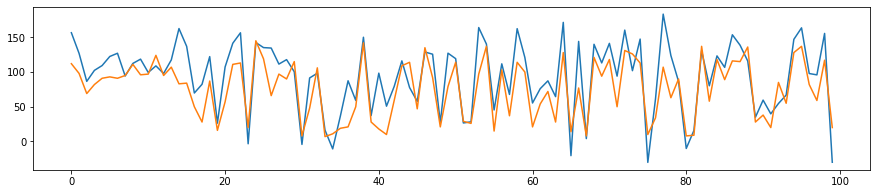

In [122]:
regr = linear_model.TheilSenRegressor()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['TheilSenRegressor'] =get_score(test_Y,prediction);

Competition Score: 8912.355638020956
MSE: 1606.58472526704
R2 score: 0.06965486840057844
MAE: 32.24745728272545


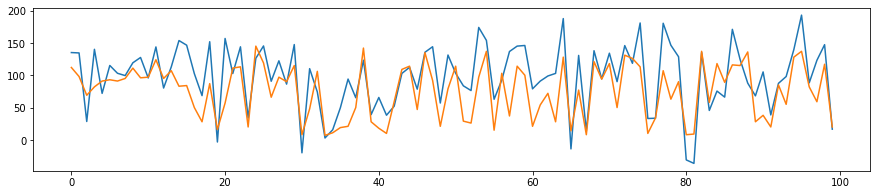

In [123]:
regr = linear_model.RANSACRegressor()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['RANSACRegressor'] =get_score(test_Y,prediction);

Competition Score: 1434.9944642169912
MSE: 704.8171578062164
R2 score: 0.5918527039874831
MAE: 20.787692221455494


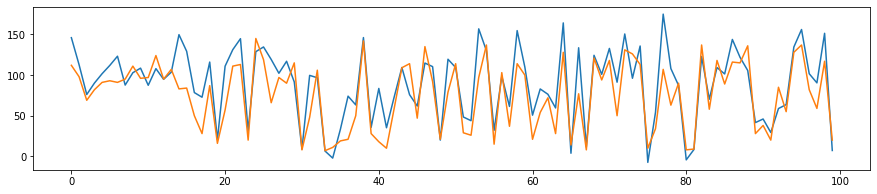

In [124]:
regr = linear_model.HuberRegressor(epsilon=1)
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['HuberRegressor'] = get_score(test_Y,prediction);

Competition Score: 2884.3572683519956
MSE: 1020.9707574053641
R2 score: 0.4087736807658411
MAE: 25.54032667123828


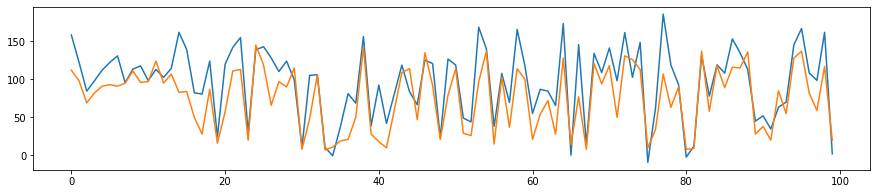

In [125]:
regr = linear_model.LinearRegression()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)


results['LinearRegression'] = get_score(test_Y,prediction);

Competition Score: 2873.412410964147
MSE: 1019.3373674464008
R2 score: 0.40971954833972357
MAE: 25.52771087411356


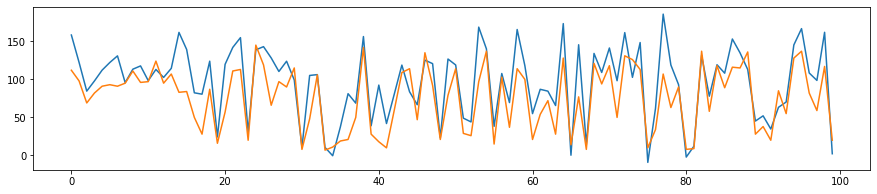

In [126]:
regr = linear_model.BayesianRidge()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['BayesianRidge'] = get_score(test_Y,prediction);

C:\Users\BERNARDO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Competition Score: 5827.752265312834
MSE: 969.05
R2 score: 0.43884008381408757
MAE: 21.89


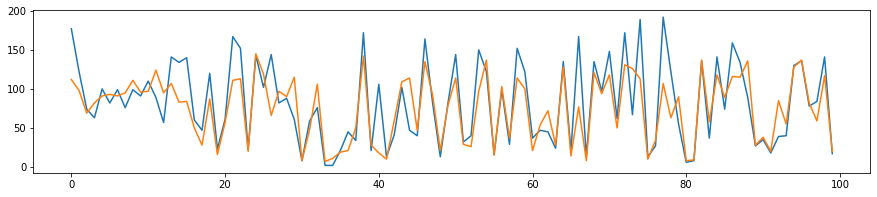

In [127]:
regr = linear_model.LogisticRegression()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['LogisticRegression'] = get_score(test_Y,prediction);

Competition Score: 2884.18764858437
MSE: 1020.9454924169933
R2 score: 0.4087883112789793
MAE: 25.54013251542001


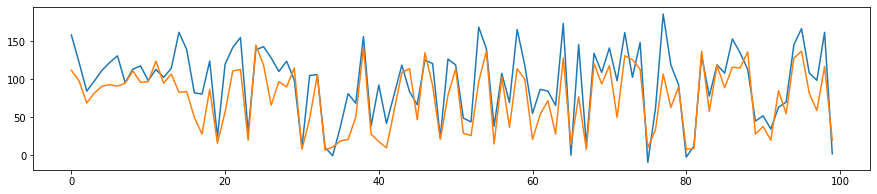

In [128]:
regr = linear_model.Ridge()
regr.fit(train_X_std, train_Y)
prediction = regr.predict(test_X_std)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['Ridge'] = get_score(test_Y,prediction);

Competition Score: 6944.127303659066
MSE: 1103.4385
R2 score: 0.3610180525501172
MAE: 24.080800000000004


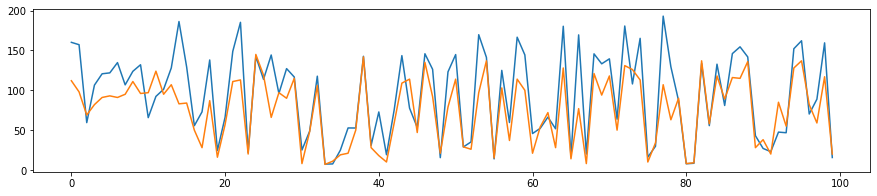

In [129]:
regr = RandomForestRegressor()
regr.fit(train_X, train_Y)
prediction = regr.predict(test_X)

fig,ax = plt.subplots(figsize=(15,3))
ax.plot(pd.Series(prediction))
ax.plot(test_Y)

results['RandomForestRegressor'] = get_score(test_Y,prediction);

In [135]:
res = pd.DataFrame(results).T.rename(columns={0:'Competition_Score',1:'MSE',2:'R2_score',3:'MAE'})

In [137]:
res = res.sort_values('Competition_Score')

In [138]:
res

,Competition_Score,MSE,R2_score,MAE
SVR,7.907796e+02,467.572800,0.729237,16.667977
LinearSVR,1.051285e+03,453.277201,0.737515,16.462524
HuberRegressor,1.434994e+03,704.817158,0.591853,20.787692
SGDRegressor,1.913688e+03,907.389600,0.474547,24.644373
KNeighborsRegressor,2.507412e+03,947.523783,0.451306,24.151579
MLPRegressor,2.539439e+03,987.828051,0.427966,25.334867
PLSRegression,2.858122e+03,975.864960,0.434894,24.463938
BayesianRidge,2.873412e+03,1019.337367,0.409720,25.527711
Ridge,2.884188e+03,1020.945492,0.408788,25.540133
LinearRegression,2.884357e+03,1020.970757,0.408774,25.540327


#### To do
- Retirar colunas de alta correlação
- Transformar colunas binarias em categóricas
- Ligar com outliers (skewness)